# AlexNet Training Notebook

本 notebook 演示如何使用 `train/train_alexnet.py` 中封装的函数进行：

1. 数据加载
2. 模型训练与评估
3. 训练指标可视化
4. 超参数网格搜索实验
5. 实验结果对比与平行坐标图可视化


In [2]:
# 如果你的 notebook 已经在 PyTorch_Learning/notebooks 里启动
import os
import sys

from utils import PROJECT_ROOT

# 确保能 import utils/ 和 train/ 里的模块
sys.path.append(os.path.abspath(".."))
print("项目根目录：", os.path.abspath(".."))

# 输出目录
outputs_dir = os.path.join(PROJECT_ROOT, "outputs")
print("Outputs 目录：", outputs_dir)

from train.train_alexnet import get_cifar10_loader

# 构造数据加载器
train_loader = get_cifar10_loader(train=True)
test_loader  = get_cifar10_loader(train=False)


项目根目录： C:\Users\WHY\Projects\Personal\PyTorch_Learning
Outputs 目录： C:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs
Files already downloaded and verified
Files already downloaded and verified


[AlexNet] Using device: cpu
Files already downloaded and verified
Files already downloaded and verified

=== Epoch 1 ===
[12800/50000] loss: 2.1959
[25600/50000] loss: 1.8220
[38400/50000] loss: 1.6018
Val loss: 1.3585, Acc: 50.49%
  → loss improved, saved to C:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\alexnet\alexnet_best.pth

=== Epoch 2 ===
[12800/50000] loss: 1.3230
[25600/50000] loss: 1.2019
[38400/50000] loss: 1.1194
Val loss: 1.0729, Acc: 62.74%
  → loss improved, saved to C:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\alexnet\alexnet_best.pth

=== Epoch 3 ===
[12800/50000] loss: 0.9522
[25600/50000] loss: 0.9234
[38400/50000] loss: 0.8828
Val loss: 0.8794, Acc: 69.95%
  → loss improved, saved to C:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\alexnet\alexnet_best.pth
Metrics: [(1.3584906148910523, 50.49), (1.0728816282749176, 62.74), (0.8794100970029831, 69.95)]


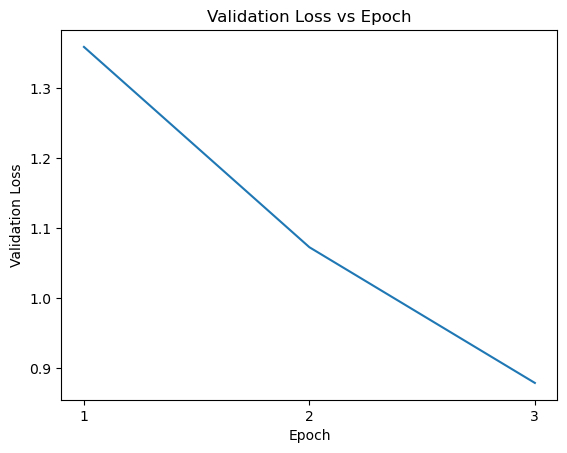

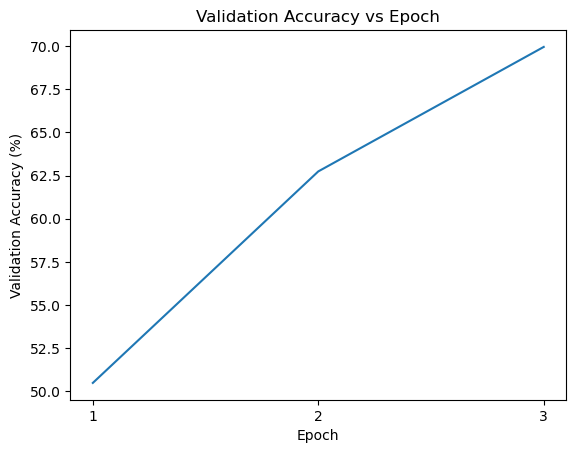

In [2]:
from train.train_alexnet import run_alexnet_training
from utils.visualization import plot_training_metrics

# run_alexnet_training 返回 [(val_loss, val_acc), ...]
metrics = run_alexnet_training(epochs=3, log_interval=200)
print("Metrics:", metrics)

# 可视化并保存
metrics_dir = os.path.join(outputs_dir, "alexnet_metrics")
plot_training_metrics(metrics, save_path=metrics_dir)


In [6]:
# --------------------------------------------
# alexnet_grid_search.py  ——  仅做必要修正
# --------------------------------------------
import os                                                # ← 加上这一行

from train.train_alexnet import run_alexnet_training
from utils.experiment import save_experiment_results
from utils.visualization import plot_experiment_comparison

# 定义超参数网格
# SAFER PARAM GRID – 几乎不会 NaN
param_grid = [
    # ★ 推荐的起步配置：SGD + lr 0.01
    {"lr": 0.01,  "momentum": 0.9, "batch_size": 128, "weight_decay": 5e-4, "patience": 5, "min_delta": 1e-3},

    # 学习率再小一档，适合刚接触时先冒烟
    {"lr": 0.005, "momentum": 0.9, "batch_size": 128, "weight_decay": 5e-4, "patience": 5, "min_delta": 1e-3},

    # 经典 AdamW（如果 run_alexnet_training 支持 `optimizer="adamw"`，可放开）
    # {"lr": 0.001, "momentum": 0.0, "batch_size": 128, "weight_decay": 1e-3, "patience": 6, "min_delta": 1e-3, "optimizer": "adamw"},

    # 大 batch 时再降半档学习率
    {"lr": 0.001, "momentum": 0.9, "batch_size": 256, "weight_decay": 5e-4, "patience": 7, "min_delta": 1e-3},

    # 极低学习率兜底（几乎不可能 NaN，但收敛会慢）
    
    {"lr": 0.0005,"momentum": 0.9, "batch_size": 256, "weight_decay": 1e-4, "patience": 8, "min_delta": 1e-3},
]

all_results = []
for cfg in param_grid:
    # ① 先把输出子目录拼出来
    output_dir = os.path.join(
        PROJECT_ROOT,
        "outputs",
        "alexnet",
        f"lr{cfg['lr']}_mom{cfg['momentum']}_bs{cfg['batch_size']}_pat{cfg['patience']}"
    )
    os.makedirs(output_dir, exist_ok=True)               # ← 保证目录存在

    # ② 跑训练
    metrics = run_alexnet_training(
        epochs=20,
        train_batch_size=cfg["batch_size"],
        test_batch_size=100,
        lr=cfg["lr"],
        momentum=cfg["momentum"],
        weight_decay=cfg["weight_decay"],
        patience=cfg["patience"],
        min_delta=cfg["min_delta"],
        log_interval=200,
        output_dir=output_dir,                           # ← 用刚才确保存在的目录
    )
    all_results.append({"config": cfg, "metrics": metrics})

# ③ 保存所有实验结果
os.makedirs(outputs_dir, exist_ok=True)                  # ← 如果外层没建好，先建再写
save_experiment_results(
    all_results,
    os.path.join(outputs_dir, "alexnet_experiment_results.json")
)

# ④ 画准确率对比图
plot_experiment_comparison(all_results, metric="accuracy")


[AlexNet] Using device: cpu
Files already downloaded and verified
Files already downloaded and verified

=== Epoch 1 ===
[25600/50000] loss: 2.2149
Val loss: 1.5711, Acc: 41.84%
  → loss improved, saved to C:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\alexnet\lr0.01_mom0.9_bs128_pat5\alexnet_best.pth

=== Epoch 2 ===
[25600/50000] loss: 1.4713
Val loss: 1.1403, Acc: 59.84%
  → loss improved, saved to C:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\alexnet\lr0.01_mom0.9_bs128_pat5\alexnet_best.pth

=== Epoch 3 ===
[25600/50000] loss: 1.1353


KeyboardInterrupt: 

In [4]:
from utils import plot_hyperparam_parallel
from utils.experiment import load_experiment_results

# 加载并可视化
results = load_experiment_results(os.path.join(outputs_dir, "alexnet_experiment_results.json"))
plot_hyperparam_parallel(results)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\WHY\\Projects\\Personal\\PyTorch_Learning\\outputs\\alexnet_experiment_results.json'